In [1]:
using DigitalComm
using Plots

In [18]:
function doPlot(snrVect, ber, qamVect)
    # Replace zero or negative BER values with a small positive value
    ber[ber .<= 0] .= 10 * 1e-10

    p = plot(
        snrVect, ber[1, :], 
        yscale = :log10, 
        label = "QPSK", 
        xlabel = "SNR [dB]", 
        ylabel = "Bit Error Rate", 
        title = "AWGN BER for QAM", 
        legend = :topright, 
        markershape = :square, 
        markercolor = :red,
        line = :solid,
        linewidth = 2
    )
    plot!(p, snrVect, ber[2, :], label = "16-QAM", markershape = :circle, markercolor = :green, linewidth = 2)
    plot!(p, snrVect, ber[3, :], label = "64-QAM", markershape = :rtriangle, markercolor = :purple, linewidth = 2)
    plot!(p, snrVect, ber[4, :], label = "256-QAM", markershape = :diamond, markercolor = :blue, linewidth = 2)

    snrLin = (10.0).^(snrVect / 10)
    for qamScheme in qamVect
        ebNo = snrLin / log2(qamScheme)
        berTheo = 4 * (1 - 1 / sqrt(qamScheme)) / log2(qamScheme) * qFunc.(sqrt.(2 * ebNo * 3 * log2(qamScheme) / (2 * (qamScheme - 1))))
        plot!(p, snrVect, berTheo, label = "Theoretical $(qamScheme)-QAM", linecolor = :black, linewidth = 2, linestyle = :dash)
    end

    display(p)
end


doPlot (generic function with 1 method)

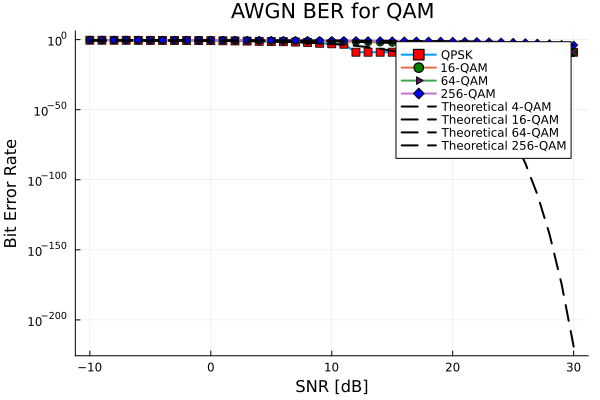

In [19]:
qamVect         = [4, 16, 64, 256]
nbSymb          = 1000
nbIt            = 10
snrVect         = -10:30
nbSNR           = length(snrVect)
ber             = zeros(Float64, length(qamVect), nbSNR)
qamSeq          = zeros(Complex{Float64}, nbSymb)
qamNoise        = zeros(Complex{Float64}, nbSymb)

for iN in 1:length(qamVect)
    mcs = qamVect[iN]
    n   = Int(log2(mcs))
    nbBits = nbSymb * n
    bitSeq = zeros(UInt8, nbBits)
    bitDec = zeros(UInt8, nbBits)
    
    for k in 1:nbSNR
        nbC = 0
        nbE = 0
        for i in 1:nbIt
            genBitSequence!(bitSeq, nbBits)
            bitMappingQAM!(qamSeq, mcs, bitSeq)
            addNoise!(qamNoise, qamSeq, snrVect[k], 1)
            bitDemappingQAM!(bitDec, mcs, qamNoise)
            nbE += sum(xor.(bitDec, bitSeq))
            nbC += length(bitSeq)
        end
        ber[iN, k] = nbE / nbC
    end
end

doPlot(snrVect, ber, qamVect)
